In [1]:
import dolfinx as dlx
import numpy as np
import pyvista as pv
from mpi4py import MPI

from ls_prior import builder

In [3]:
mpi_communicator = MPI.COMM_WORLD
mesh, *_ = dlx.io.gmshio.read_from_msh("sphere_surface.msh", mpi_communicator, rank=0, gdim=3)
num_vertices = mesh.geometry.x.shape[0]
mean_vector = np.zeros(num_vertices)

Info    : Reading 'sphere_surface.msh'...
Info    : 7 entities
Info    : 1585 nodes
Info    : 3166 elements
Info    : Done reading 'sphere_surface.msh'


In [4]:
prior_settings = builder.BilaplacianPriorSettings(
    mesh=mesh,
    mean_vector=mean_vector,
    kappa=100,
    tau=0.01,
)
prior_builder = builder.BilaplacianPriorBuilder(prior_settings)
bilaplace_prior = prior_builder.build()

In [5]:
test_vector_1 = np.ones_like(mean_vector)
test_vector_2 = 2*np.ones_like(mean_vector)
test_vector_3 = 3*np.ones_like(mean_vector)
cost = bilaplace_prior.evaluate_cost(test_vector_1)
grad = bilaplace_prior.evaluate_gradient(test_vector_2)
hvp = bilaplace_prior.evaluate_hessian_vector_product(test_vector_3)
sample = bilaplace_prior.generate_sample()
print(cost)
print(grad)
print(hvp)
print(sample)

62709.907977619965
[198.81520053 223.08966619 204.38470718 ... 165.23311024 160.717126
 166.03708556]
[298.2228008  334.63449929 306.57706077 ... 247.84966535 241.075689
 249.05562834]
[-0.1302421   0.03832716  0.03325257 ... -0.09843029 -0.0545724
  0.19012541]


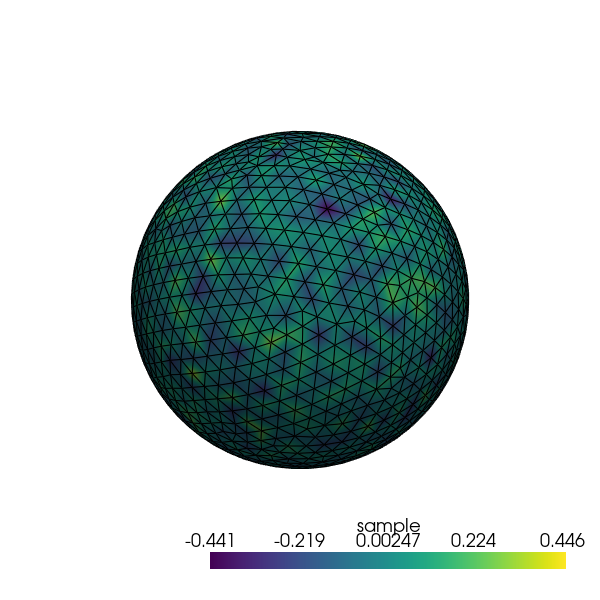

In [6]:
mesh_vertices = mesh.geometry.x
mesh_faces = mesh.geometry.dofmap
mesh_faces = np.hstack([np.full((mesh_faces.shape[0], 1), 3), mesh_faces])

pv_mesh = pv.PolyData(mesh_vertices, mesh_faces)
pv_mesh.point_data["sample"] = sample
plotter = pv.Plotter()
plotter.add_mesh(pv_mesh, scalars="sample", cmap="viridis", show_edges=True, show_scalar_bar=True)
plotter.show(window_size=[600, 600])